In [2]:
import pandas as pd 
import numpy as np 
import re
from fuzzywuzzy import process, fuzz
import os
import shutil
import glob
from PIL import Image
from difflib import SequenceMatcher

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## For Data Processing 

In [4]:
city_names = [
    'Giza', 'Cairo', 'Sharm El Sheikh', 'Hurghada', 'North Coast', 'Alexandria',
    'Fayoum', 'Beni Suef', 'Marsa Matrouh', 'Marsa Alam', 'El Gouna', 'Dahab',
    'Sinai', 'Red Sea', 'Suez', 'Assiut', 'New Valley', 'Aswan', 'Luxor',
    'Beheira', 'Sohag', 'Minya', 'Ismailia', 'Port Said', 'Qena', 'Qalyubia', 'Sharqia'
]

In [5]:
def add_sequential_id(df, start_range):    
    df = df.copy()  
    id_list = list(range(start_range, start_range + df.shape[0]))  
    
    df.insert(0, 'id', id_list) 
    
    return df

### Activities IDs Ranges

In [6]:
# safari_data             Range ---> 7000
# ballon_tours_data       Range ---> 8000
# camel_tour              Range ---> 9000
# diving_data             Range ---> 10000
# submarine_tour          Range ---> 11000
# swimming_and_dolphins   Range ---> 12000

In [7]:
def insert_tourism_type(df, tourism_type):
    df = df.copy()  
    df['Activity Type'] = tourism_type 
    return df

In [8]:
def extract_city_name(title, cities):
    
    for city in cities:
        if re.search(rf"\b{re.escape(city)}\b", title, re.IGNORECASE):
            return city  
    
    best_match = process.extractOne(title, cities, scorer=fuzz.partial_ratio)
    if best_match and best_match[1] >= 75:
        return best_match[0]
    
    return None  

In [9]:
def show_image(image_path):
    
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    cleaned_path = image_path.strip("\u202a")

    img = mpimg.imread(cleaned_path)
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.imshow(img)
    ax.axis('off')  
    plt.show()

In [10]:
def get_best_match(title, files, threshold=0.68):
    best_match = None
    best_ratio = 0

    for file in files:
        filename = os.path.splitext(os.path.basename(file))[0]  
        ratio = SequenceMatcher(None, title.lower(), filename.lower()).ratio()

        if ratio > best_ratio and ratio >= threshold:
            best_match = file
            best_ratio = ratio

    return best_match

def move_image_to_id_file(df, old_folder_path, new_folder_path):
    all_images = glob.glob(os.path.join(old_folder_path, "*.*")) 
    missing_ids = []  

    for _, row in df.iterrows():
        title_clean = str(row['Title']).strip()
        best_match = get_best_match(title_clean, all_images, threshold=0.75)

        if best_match:
            old_image_path = best_match
            file_extension = os.path.splitext(old_image_path)[1]
            webp_image_path = os.path.splitext(old_image_path)[0] + ".webp"

            if file_extension.lower() != ".webp":
                with Image.open(old_image_path) as img:
                    img.save(webp_image_path, "WEBP")
                os.remove(old_image_path)
                print(f"✅ Converted: {old_image_path} → {webp_image_path}")
            else:
                webp_image_path = old_image_path  

            id_folder = os.path.join(new_folder_path, str(row['id']))
            os.makedirs(id_folder, exist_ok=True)
            new_image_path = os.path.join(id_folder, os.path.basename(webp_image_path))

            shutil.move(webp_image_path, new_image_path)
            print(f"📂 Moved: {webp_image_path} → {new_image_path}")
        else:
            missing_ids.append(row['id'])  

    return missing_ids 


## Data Uploading 

In [11]:
safari_data = pd.read_csv("safari_data.csv")
ballon_tours_data = pd.read_csv("ballon_tours_data.csv")
camel_tour = pd.read_csv("camel_tour.csv")
diving_data = pd.read_csv("diving_data.csv")
submarine_tour = pd.read_csv("submarine_tour.csv")
swimming_and_dolphins = pd.read_csv("swimming_and_dolphins.csv")

## Safari Data Processing

In [12]:
safari_data.head()

,Title,Rating,Price,Link
0,"Sharm El-Sheikh: Ultimate ATV Quad, Stargazing...",4.8,"From\nE£2,001\nFrom\nE£1,000\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...
1,Hurghada: Desert Quad Bike Camel Ride with Opt...,4.5,From\nE£886\nFrom\nE£443\nper person,https://www.getyourguide.com/hurghada-l403/hur...
2,Giza Sunrise Pyramid Guided Tour With Camel Ri...,4.8,"From\nE£2,046\nFrom\nE£1,023\nper person",https://www.getyourguide.com/cairo-l92/giza-su...
3,"Hurghada: VIP Quad, Sea, Camel, Safari, Starga...",4.3,From\nE£545\nFrom\nE£327\nper person,https://www.getyourguide.com/hurghada-l403/hur...
4,"Hurghada: Sunset Quad Bike, Camel w/ Opt Starg...",4.4,From\nE£852\nFrom\nE£511\nper person,https://www.getyourguide.com/hurghada-l403/sun...


In [13]:
safari_data['City'] = safari_data['Title'].apply(lambda x: extract_city_name(x, city_names))

In [14]:
for i in safari_data[safari_data['City'].isna()]['Title'] : 
    print(i)

Makadi Bay: Sunset Quad & ATV Adventure & Seaview
camel ride with sunset and star watching
Desert Sunset Quad Biking Safari, Dinner, Camel Ride
Discover Wadi Hitan, Egypts Prehistoric Wonder!
All-inclusive private Trip Pyramids Sphinx, Camel, VIP Lunch
Morning Trip: Desert Safari Riding a Speed Quad Bike, Pickup
Makadi Bay: Mega Tour Jeep, ATV, Buggy, Camel, Dinner & Show
Desert Safari by Quad Bike Around Pyramids
2-Day Black & White Deserts Tour and Activities
Makadi Bay: 2H Quad Bike, Camel, Stargazing, Dinner & Show


In [15]:
safari_data = safari_data.dropna(subset=['City'])

In [16]:
safari_data.head()

,Title,Rating,Price,Link,City
0,"Sharm El-Sheikh: Ultimate ATV Quad, Stargazing...",4.8,"From\nE£2,001\nFrom\nE£1,000\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh
1,Hurghada: Desert Quad Bike Camel Ride with Opt...,4.5,From\nE£886\nFrom\nE£443\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
2,Giza Sunrise Pyramid Guided Tour With Camel Ri...,4.8,"From\nE£2,046\nFrom\nE£1,023\nper person",https://www.getyourguide.com/cairo-l92/giza-su...,Giza
3,"Hurghada: VIP Quad, Sea, Camel, Safari, Starga...",4.3,From\nE£545\nFrom\nE£327\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
4,"Hurghada: Sunset Quad Bike, Camel w/ Opt Starg...",4.4,From\nE£852\nFrom\nE£511\nper person,https://www.getyourguide.com/hurghada-l403/sun...,Hurghada


In [17]:
safari_data = add_sequential_id (safari_data, 7000)

In [18]:
safari_data.head()

,id,Title,Rating,Price,Link,City
0,7000,"Sharm El-Sheikh: Ultimate ATV Quad, Stargazing...",4.8,"From\nE£2,001\nFrom\nE£1,000\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh
1,7001,Hurghada: Desert Quad Bike Camel Ride with Opt...,4.5,From\nE£886\nFrom\nE£443\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
2,7002,Giza Sunrise Pyramid Guided Tour With Camel Ri...,4.8,"From\nE£2,046\nFrom\nE£1,023\nper person",https://www.getyourguide.com/cairo-l92/giza-su...,Giza
3,7003,"Hurghada: VIP Quad, Sea, Camel, Safari, Starga...",4.3,From\nE£545\nFrom\nE£327\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
4,7004,"Hurghada: Sunset Quad Bike, Camel w/ Opt Starg...",4.4,From\nE£852\nFrom\nE£511\nper person,https://www.getyourguide.com/hurghada-l403/sun...,Hurghada


In [19]:
# move_image_to_id_file(safari_data,"F:\Egyptopia\Activities Backup\Safari\Safari images","F:\Egyptopia\Activities For Production\Safari")

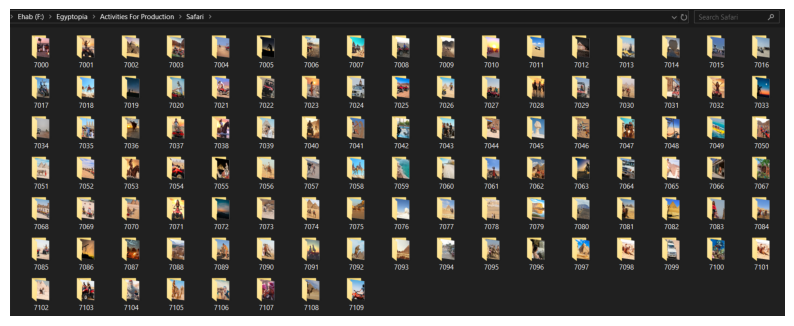

In [20]:
show_image(r"‪F:\Egyptopia\Activities Scrap\Logo\safari_images.png")

## Ballon Tours Dataset Handling

In [21]:
ballon_tours_data.head()

,Title,Rating,Price,Link
0,Luxor: Hot Air Balloon Ride over Luxor Relics,4.9,"From\nE£4,681\nFrom\nE£3,277\nper person",https://www.getyourguide.com/luxor-l109/luxor-...
1,Hurghada: Luxor Hot Air Balloon Ride and Day T...,4.4,"From\nE£7,900\nper person",https://www.getyourguide.com/hurghada-l403/fro...
2,Luxor: Morning Hot Air Balloon Ride,4.4,"From\nE£2,896\nper person",https://www.getyourguide.com/luxor-l109/luxor-...
3,Luxor: Hot Air Balloon Ride with Full-Day Sigh...,5.0,"From\nE£8,427\nFrom\nE£4,634\nper person",https://www.getyourguide.com/luxor-l109/luxor-...
4,"Hurghada: 2-Day Luxor Tour with Hotel, Balloon...",4.5,"From\nE£13,167\nper person",https://www.getyourguide.com/luxor-l109/hurgha...


In [22]:
ballon_tours_data['City'] = ballon_tours_data['Title'].apply(lambda x: extract_city_name(x, city_names))

In [23]:
for i in ballon_tours_data[ballon_tours_data['City'].isna()]['Title'] : 
    print(i)

Egypt: Private 5-Day Tour, Nile Cruise, Flights, Balloon
East and west banks private day tour included Balloon Ride


In [24]:
ballon_tours_data = ballon_tours_data.dropna(subset=['City'])

In [25]:
ballon_tours_data = add_sequential_id (ballon_tours_data, 8000)

In [26]:
ballon_tours_data

,id,Title,Rating,Price,Link,City
0,8000,Luxor: Hot Air Balloon Ride over Luxor Relics,4.9,"From\nE£4,681\nFrom\nE£3,277\nper person",https://www.getyourguide.com/luxor-l109/luxor-...,Luxor
1,8001,Hurghada: Luxor Hot Air Balloon Ride and Day T...,4.4,"From\nE£7,900\nper person",https://www.getyourguide.com/hurghada-l403/fro...,Hurghada
2,8002,Luxor: Morning Hot Air Balloon Ride,4.4,"From\nE£2,896\nper person",https://www.getyourguide.com/luxor-l109/luxor-...,Luxor
3,8003,Luxor: Hot Air Balloon Ride with Full-Day Sigh...,5.0,"From\nE£8,427\nFrom\nE£4,634\nper person",https://www.getyourguide.com/luxor-l109/luxor-...,Luxor
4,8004,"Hurghada: 2-Day Luxor Tour with Hotel, Balloon...",4.5,"From\nE£13,167\nper person",https://www.getyourguide.com/luxor-l109/hurgha...,Hurghada
...,...,...,...,...,...,...
63,8061,From Marsa Alam: 5-Day Egypt Tour with Nile Cr...,4.4,"From\nE£63,954\nper person",https://www.getyourguide.com/luxor-l109/from-m...,Marsa Alam
64,8062,From Marsa Alam: 3 night Nile Cruise with Hot ...,4.4,"From\nE£56,430\nper person",https://www.getyourguide.com/luxor-l109/from-m...,Marsa Alam
65,8063,"Hurghada:10-Day Egypt Tour, Nile Cruise, Ballo...",5.0,"From\nE£56,355\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
66,8064,Marsa Alam: 4 Days Nile cruise to Aswan with h...,4.4,"From\nE£56,430\nper person",https://www.getyourguide.com/marsa-alam-l422/m...,Marsa Alam


In [27]:
# move_image_to_id_file(ballon_tours_data,"F:\\Egyptopia\\Activities Backup\\Balloon tours\Balloon tours images",
#                       "F:\\Egyptopia\\Activities For Production\\ballon tours")

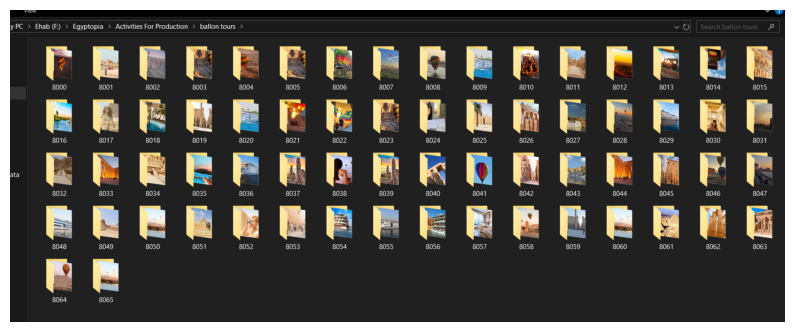

In [28]:
show_image(r"‪‪F:\Egyptopia\Activities Scrap\Logo\ballon_tours.png")

## Camel Tour Dataset Handling

In [29]:
camel_tour.head()

,Title,Rating,Price,Link
0,"Sharm El-Sheikh: Ultimate ATV Quad, Stargazing...",4.8,"From\nE£2,001\nFrom\nE£1,000\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...
1,Cairo: Pyramids & Great Sphinx Private Tour wi...,4.9,"From\nE£1,158\nFrom\nE£1,042\nper person",https://www.getyourguide.com/cairo-l92/private...
2,Hurghada: Desert Quad Bike Camel Ride with Opt...,4.5,From\nE£886\nFrom\nE£443\nper person,https://www.getyourguide.com/hurghada-l403/hur...
3,"Hurghada: VIP Quad, Sea, Camel, Safari, Starga...",4.3,From\nE£545\nFrom\nE£327\nper person,https://www.getyourguide.com/hurghada-l403/hur...
4,Giza Sunrise Pyramid Guided Tour With Camel Ri...,4.8,"From\nE£2,046\nFrom\nE£1,023\nper person",https://www.getyourguide.com/cairo-l92/giza-su...


In [30]:
camel_tour['City'] = camel_tour['Title'].apply(lambda x: extract_city_name(x, city_names))

In [31]:
camel_tour = camel_tour.dropna(subset=['City'])

In [32]:
camel_tour = add_sequential_id (camel_tour, 9000)

In [33]:
camel_tour

,id,Title,Rating,Price,Link,City
0,9000,"Sharm El-Sheikh: Ultimate ATV Quad, Stargazing...",4.8,"From\nE£2,001\nFrom\nE£1,000\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh
1,9001,Cairo: Pyramids & Great Sphinx Private Tour wi...,4.9,"From\nE£1,158\nFrom\nE£1,042\nper person",https://www.getyourguide.com/cairo-l92/private...,Cairo
2,9002,Hurghada: Desert Quad Bike Camel Ride with Opt...,4.5,From\nE£886\nFrom\nE£443\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
3,9003,"Hurghada: VIP Quad, Sea, Camel, Safari, Starga...",4.3,From\nE£545\nFrom\nE£327\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
4,9004,Giza Sunrise Pyramid Guided Tour With Camel Ri...,4.8,"From\nE£2,046\nFrom\nE£1,023\nper person",https://www.getyourguide.com/cairo-l92/giza-su...,Giza
...,...,...,...,...,...,...
85,9079,"Sharm El Sheikh: Quad Biking, Camel Ride & Bed...",4.6,"From\nE£1,715\nFrom\nE£909\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh
86,9080,"VIP Cairo Experience: Pyramids, ATV Adventure ...",4.3,"From\nE£12,278\nFrom\nE£9,208\nper person",https://www.getyourguide.com/cairo-l92/vip-cai...,Cairo
87,9081,"Hurghada: 4 Days Tour Horse, Camel, Spa, ATV, ...",4.3,"From\nE£1,580\nper person",https://www.getyourguide.com/makadi-bay-l4675/...,Hurghada
88,9082,Desert Safari Around The Pyramids of Giza With...,4.0,"From\nE£2,182\nFrom\nE£1,309\nper person",https://www.getyourguide.com/giza-governorate-...,Giza


In [34]:
# move_image_to_id_file(camel_tour,"F:\\Egyptopia\\Activities Backup\\Camel Tours\\Camel Tours Images",
#                       "F:\\Egyptopia\\Activities For Production\\Camel Tours")

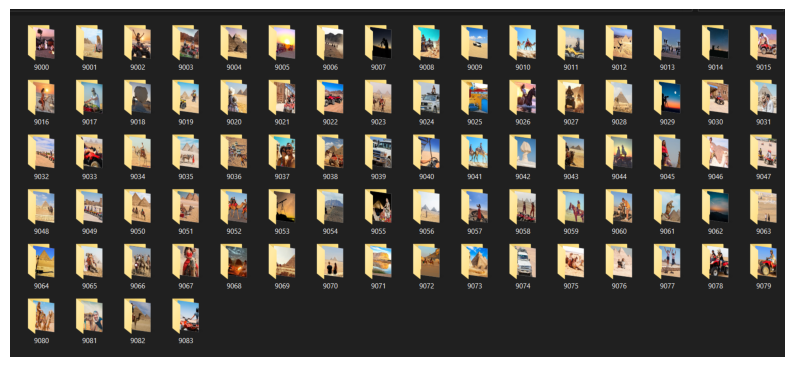

In [35]:
show_image(r"F:\Egyptopia\Activities Scrap\Logo\camel_tours.png")

## Diving Dataset Handling 

In [36]:
diving_data.head()

,Title,Rating,Price,Link
0,Hurghada or Makadi: Discover the Magic of Dolp...,4.9,"From\nE£1,715\nFrom\nE£1,320\nper person",https://www.getyourguide.com/hurghada-l403/hur...
1,Hurghada: Luxury Cruise Trip to Orange Bay wit...,4.9,"From\nE£2,949\nFrom\nE£2,802\nper person",https://www.getyourguide.com/hurghada-l403/hur...
2,Hurghada: Royal Seascope Submarine Cruise with...,4.5,"From\nE£1,264\nFrom\nE£884\nper person",https://www.getyourguide.com/hurghada-l403/hur...
3,Hurghada: 6 Islands Tour with Dolphin Watching...,4.7,"From\nE£2,972\nFrom\nE£2,675\nper person",https://www.getyourguide.com/hurghada-l403/hur...
4,"Giza: Sakkara, Memphis & Dahshur (Pyramid & Fe...",4.8,"From\nE£1,364\nFrom\nE£682\nper person",https://www.getyourguide.com/cairo-l92/giza-sa...


In [37]:
diving_data['City'] = diving_data['Title'].apply(lambda x: extract_city_name(x, city_names))

In [38]:
diving_data = diving_data.dropna(subset=['City'])

In [39]:
diving_data = add_sequential_id (diving_data, 10000)

In [40]:
diving_data

,id,Title,Rating,Price,Link,City
0,10000,Hurghada or Makadi: Discover the Magic of Dolp...,4.9,"From\nE£1,715\nFrom\nE£1,320\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
1,10001,Hurghada: Luxury Cruise Trip to Orange Bay wit...,4.9,"From\nE£2,949\nFrom\nE£2,802\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
2,10002,Hurghada: Royal Seascope Submarine Cruise with...,4.5,"From\nE£1,264\nFrom\nE£884\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
3,10003,Hurghada: 6 Islands Tour with Dolphin Watching...,4.7,"From\nE£2,972\nFrom\nE£2,675\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
4,10004,"Giza: Sakkara, Memphis & Dahshur (Pyramid & Fe...",4.8,"From\nE£1,364\nFrom\nE£682\nper person",https://www.getyourguide.com/cairo-l92/giza-sa...,Giza
...,...,...,...,...,...,...
65,10056,Sharm el Sheikh Port : Ras Mohammed Dive Trip ...,5.0,"From\nE£10,902\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh
66,10057,"Hurghada: 1 day DIVING Refrechment, 1 Check & ...",5.0,"From\nE£7,432\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
68,10058,From Alexandria Port: City Tour with Citadel a...,4.5,"From\nE£13,272\nper person",https://www.getyourguide.com/alexandria-l490/f...,Alexandria
69,10059,Hurghada: Private Speedboat To Bayoud Islands ...,3.7,"From\nE£25,726\nper group up to 2",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada


In [41]:
# move_image_to_id_file(diving_data,"F:\\Egyptopia\\Activities Backup\\Diving\\Diving Images",
#                       "F:\\Egyptopia\\Activities For Production\\Diving")

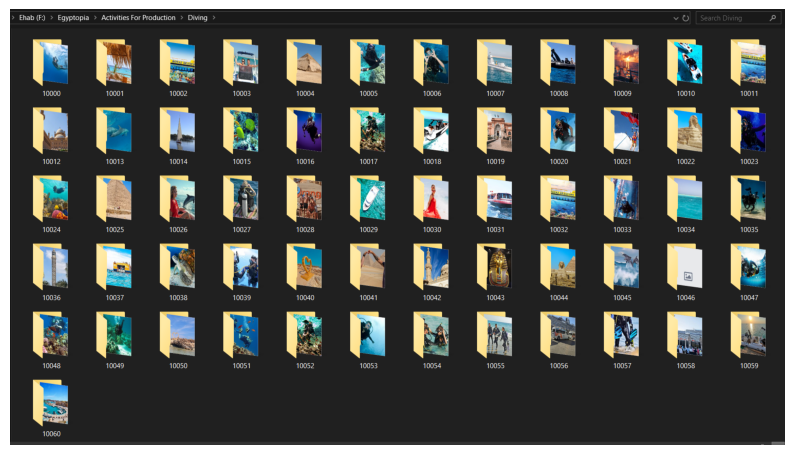

In [42]:
show_image(r"F:\Egyptopia\Activities Scrap\Logo\DivingImages.png")

## Submarine Tours Dataset Handling

In [43]:
submarine_tour.head()

,Title,Rating,Price,Link
0,Hurghada: Royal Seascope Submarine Cruise with...,4.5,"From\nE£1,264\nFrom\nE£884\nper person",https://www.getyourguide.com/hurghada-l403/hur...
1,Sharm El-Sheikh: Seascope Submarine boat cruis...,4.5,"From\nE£2,370\nFrom\nE£1,919\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...
2,Hurghada: Semi-Submarine Boat Tour w/ Snorkeli...,4.2,From\nE£421\nFrom\nE£316\nper person,https://www.getyourguide.com/hurghada-l403/hur...
3,Hurghada: Sindbad Submarines Red Sea Underwate...,5.0,"From\nE£3,944\nFrom\nE£3,550\nper person",https://www.getyourguide.com/hurghada-l403/hur...
4,Hurghada: Panoramic Semi-Submarine Cruise with...,4.5,"From\nE£1,843\nFrom\nE£921\nper person",https://www.getyourguide.com/hurghada-l403/pan...


In [44]:
submarine_tour['City'] = submarine_tour['Title'].apply(lambda x: extract_city_name(x, city_names))

In [45]:
submarine_tour = submarine_tour.dropna(subset=['City'])

In [46]:
submarine_tour = add_sequential_id (submarine_tour, 110000)

In [47]:
submarine_tour

,id,Title,Rating,Price,Link,City
0,110000,Hurghada: Royal Seascope Submarine Cruise with...,4.5,"From\nE£1,264\nFrom\nE£884\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
1,110001,Sharm El-Sheikh: Seascope Submarine boat cruis...,4.5,"From\nE£2,370\nFrom\nE£1,919\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh
2,110002,Hurghada: Semi-Submarine Boat Tour w/ Snorkeli...,4.2,From\nE£421\nFrom\nE£316\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
3,110003,Hurghada: Sindbad Submarines Red Sea Underwate...,5.0,"From\nE£3,944\nFrom\nE£3,550\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
4,110004,Hurghada: Panoramic Semi-Submarine Cruise with...,4.5,"From\nE£1,843\nFrom\nE£921\nper person",https://www.getyourguide.com/hurghada-l403/pan...,Hurghada
6,110005,Marsa Alam: Royal Seascope Submarine Cruise wi...,4.3,"From\nE£2,633\nFrom\nE£2,422\nper person",https://www.getyourguide.com/marsa-alam-l422/r...,Marsa Alam
7,110006,Hurghada: Paradise Island w/ Snorkeling & Opt ...,4.7,"From\nE£1,843\nFrom\nE£921\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
9,110007,Sharm El-Sheikh: Royal Seascope Submarine Crui...,3.9,"From\nE£2,896\nFrom\nE£2,317\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh
10,110008,Hurghada: Empire Submarine Boat Trip with Snor...,3.4,"From\nE£1,086\nFrom\nE£814\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
11,110009,From El Gouna: Royal Seascope Submarine with S...,4.0,"From\nE£1,053\nFrom\nE£895\nper person",https://www.getyourguide.com/el-gouna-l1051/fr...,El Gouna


In [48]:
# move_image_to_id_file(submarine_tour,"F:\\Egyptopia\\Activities Backup\\Submarine Tours\\Submarine Tours Images",
#                       "F:\\Egyptopia\\Activities For Production\\Submarine tours")

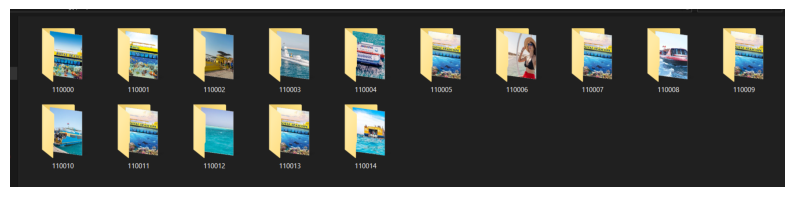

In [49]:
show_image(r"F:\Egyptopia\Activities Scrap\Logo\submarine.png")

## Swimming With Dolphins Tours Dataset Handling

In [50]:
swimming_and_dolphins.head()

,Title,Rating,Price,Link
0,Hurghada or Makadi: Discover the Magic of Dolp...,4.9,"From\nE£1,715\nFrom\nE£1,320\nper person",https://www.getyourguide.com/hurghada-l403/hur...
1,Hurghada: Dolphin World Show with Walruses and...,4.3,"From\nE£1,143\nper person",https://www.getyourguide.com/hurghada-l403/hur...
2,"Giza: Sakkara, Memphis & Dahshur (Pyramid & Fe...",4.8,"From\nE£1,364\nFrom\nE£682\nper person",https://www.getyourguide.com/cairo-l92/giza-sa...
3,Hurghada: Speedboat Dolphin Watching & Snorkel...,4.6,"From\nE£2,001\nFrom\nE£1,901\nper person",https://www.getyourguide.com/giftun-island-l45...
4,Hurghada: Dolphin Watching & Snorkeling Advent...,4.6,"From\nE£1,315\nFrom\nE£986\nper person",https://www.getyourguide.com/hurghada-l403/hur...


In [51]:
swimming_and_dolphins['City'] = swimming_and_dolphins['Title'].apply(lambda x: extract_city_name(x, city_names))

In [52]:
swimming_and_dolphins = swimming_and_dolphins.dropna(subset=['City'])

In [53]:
swimming_and_dolphins = add_sequential_id (swimming_and_dolphins, 120000)

In [54]:
swimming_and_dolphins.head()

,id,Title,Rating,Price,Link,City
0,120000,Hurghada or Makadi: Discover the Magic of Dolp...,4.9,"From\nE£1,715\nFrom\nE£1,320\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
1,120001,Hurghada: Dolphin World Show with Walruses and...,4.3,"From\nE£1,143\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada
2,120002,"Giza: Sakkara, Memphis & Dahshur (Pyramid & Fe...",4.8,"From\nE£1,364\nFrom\nE£682\nper person",https://www.getyourguide.com/cairo-l92/giza-sa...,Giza
3,120003,Hurghada: Speedboat Dolphin Watching & Snorkel...,4.6,"From\nE£2,001\nFrom\nE£1,901\nper person",https://www.getyourguide.com/giftun-island-l45...,Hurghada
4,120004,Hurghada: Dolphin Watching & Snorkeling Advent...,4.6,"From\nE£1,315\nFrom\nE£986\nper person",https://www.getyourguide.com/hurghada-l403/hur...,Hurghada


In [55]:
# missing = move_image_to_id_file(
#     swimming_and_dolphins, 
#     "F:\\Egyptopia\\Activities Backup\\Swimming and Dolphins\\Swimming and Dolphins Images",
#     "F:\\Egyptopia\\Activities For Production\\Swimming With Dolphins"
# )

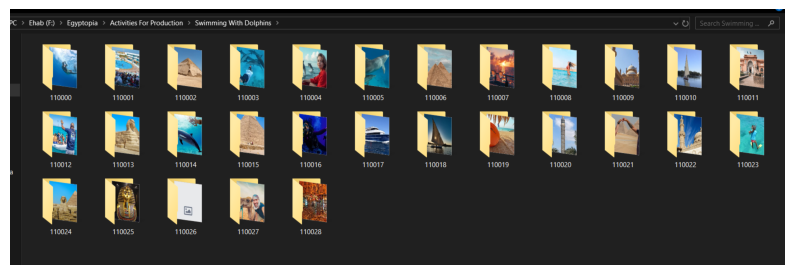

In [56]:
show_image(r"F:\Egyptopia\Activities Scrap\Logo\swimmingWithDolphins.png")

## Inserting Activities Types

In [57]:
safari_data = insert_tourism_type (safari_data, 'Safari')
ballon_tours_data = insert_tourism_type (ballon_tours_data, 'Ballon Tours')
camel_tour = insert_tourism_type (camel_tour, 'Camel Tours')
diving_data = insert_tourism_type (diving_data, 'Diving')
submarine_tour = insert_tourism_type (submarine_tour, 'Submarine Tours')
swimming_and_dolphins = insert_tourism_type (swimming_and_dolphins, 'Swimming With Dolphins')

## Merging Datasets After Processing 

In [58]:
activities_df = pd.concat([safari_data, ballon_tours_data, camel_tour, diving_data, submarine_tour, swimming_and_dolphins], ignore_index=True)

In [59]:
activities_df

,id,Title,Rating,Price,Link,City,Activity Type
0,7000,"Sharm El-Sheikh: Ultimate ATV Quad, Stargazing...",4.8,"From\nE£2,001\nFrom\nE£1,000\nper person",https://www.getyourguide.com/sharm-el-sheikh-l...,Sharm El Sheikh,Safari
1,7001,Hurghada: Desert Quad Bike Camel Ride with Opt...,4.5,From\nE£886\nFrom\nE£443\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada,Safari
2,7002,Giza Sunrise Pyramid Guided Tour With Camel Ri...,4.8,"From\nE£2,046\nFrom\nE£1,023\nper person",https://www.getyourguide.com/cairo-l92/giza-su...,Giza,Safari
3,7003,"Hurghada: VIP Quad, Sea, Camel, Safari, Starga...",4.3,From\nE£545\nFrom\nE£327\nper person,https://www.getyourguide.com/hurghada-l403/hur...,Hurghada,Safari
4,7004,"Hurghada: Sunset Quad Bike, Camel w/ Opt Starg...",4.4,From\nE£852\nFrom\nE£511\nper person,https://www.getyourguide.com/hurghada-l403/sun...,Hurghada,Safari
...,...,...,...,...,...,...,...
360,120024,"Cairo: 2-Day Pyramid, Museum, Bazaar Private Tour",4.5,"From\nE£4,092\nFrom\nE£2,046\nper person",https://www.getyourguide.com/cairo-l92/cairo-2...,Cairo,Swimming With Dolphins
361,120025,Cairo: Private Pharaonic Village Tour With Tan...,4.5,"From\nE£2,387\nFrom\nE£1,551\nper person",https://www.getyourguide.com/cairo-l92/cairo-p...,Cairo,Swimming With Dolphins
362,120026,Cairo: VIP Pyramids Sound & Light Show With Pr...,3.4,"From\nE£3,069\nFrom\nE£1,995\nper person",https://www.getyourguide.com/cairo-l92/cairo-v...,Cairo,Swimming With Dolphins
363,120027,"Hurghada: 4 Days Tour Horse, Camel, Spa, ATV, ...",4.3,"From\nE£12,278\nFrom\nE£9,208\nper person",https://www.getyourguide.com/makadi-bay-l4675/...,Hurghada,Swimming With Dolphins


## Uploading data To csv format

In [60]:
activities_df.to_csv("activitiesForEgyptopia.csv", index=False)

In [61]:
activities_df.columns

Index(['id', 'Title', 'Rating', 'Price', 'Link', 'City', 'Activity Type'], dtype='object')